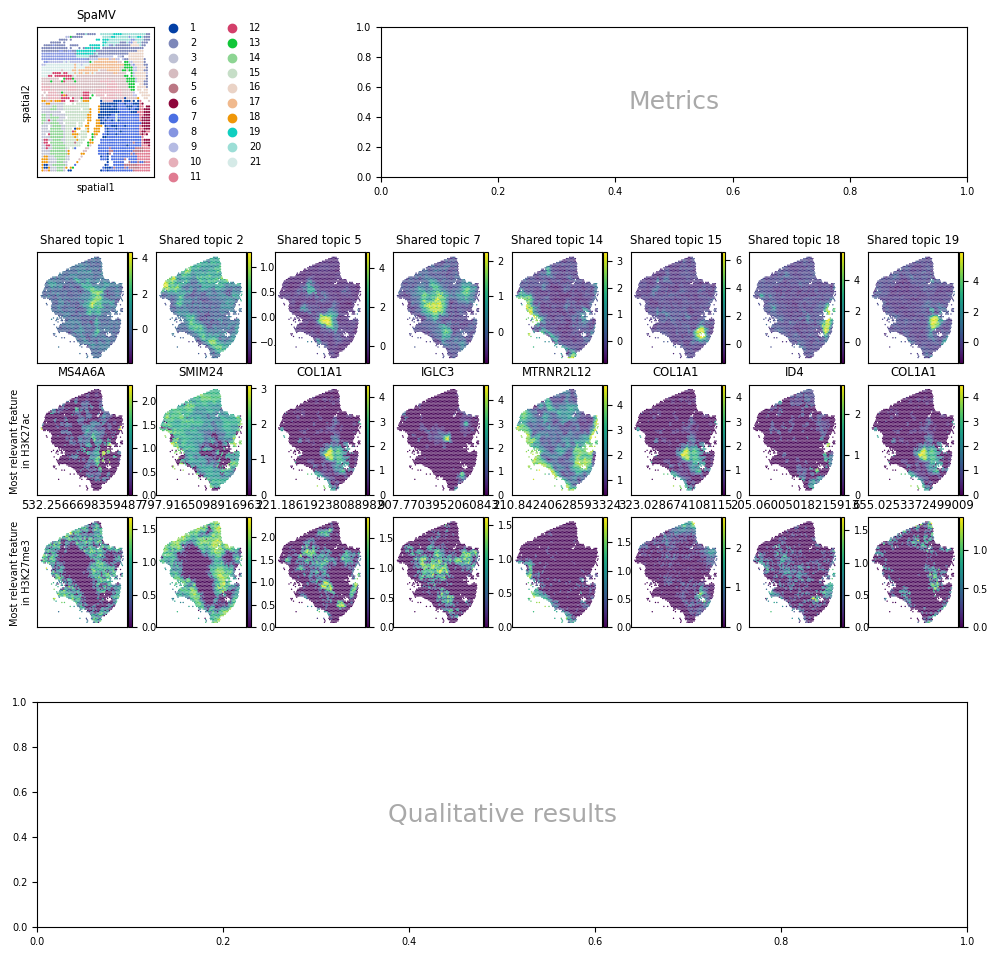

In [23]:
import matplotlib
import warnings

warnings.filterwarnings("ignore")
import scanpy as sc
from scanpy.plotting import embedding
from sklearn.metrics import adjusted_rand_score
import scvi
import squidpy as sq
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.gridspec import GridSpec

font = {'size': 7}

matplotlib.rc('font', **font)


def annotate_axes(ax, text, fontsize=18):
    ax.text(0.5, 0.5, text, transform=ax.transAxes,
            ha="center", va="center", fontsize=fontsize, color="darkgrey")

n_topics = 10
cluster_size = 20
cluster_size_4 = 10
dr_size = 50
width = 12
height = 15
# load mouse embryo dataset
fig = plt.figure(figsize=(width, height))
spec_clustering = GridSpec(1, 3, width_ratios=[1, 1, 5])
spec_clustering.update(top=.95, bottom=.85)
spamv = plt.subplot(spec_clustering[0, 0])
unknown1 = plt.subplot(spec_clustering[0, 2])
annotate_axes(unknown1, 'Metrics')

data_rna = sc.read_h5ad('../Dataset/8_ccRCC_R114_T/adata_RNA.h5ad')
data_sm = sc.read_h5ad('../Dataset/8_ccRCC_R114_T/adata_SM.h5ad')
data_rna = data_rna[:, (data_rna.X > 1).sum(0) > data_rna.n_obs / 100]
sc.pp.filter_genes(data_rna, min_cells=10)
sc.pp.filter_cells(data_rna, min_counts=200)
sc.pp.normalize_total(data_rna)
sc.pp.log1p(data_rna)

data_sm = data_sm[:, (data_sm.X > 1).sum(0) > data_sm.n_obs / 100]
data_sm = data_sm[data_sm.obs_names.intersection(data_rna.obs_names)]
sc.pp.normalize_total(data_sm)
sc.pp.log1p(data_sm)
data_spamv = sc.read_h5ad('../Results/7_ME13_1/adata_SpaMV.h5ad')
data_spamv.uns.pop('SpaMV_colors')

embedding(data_spamv, color='SpaMV', basis='spatial', ax=spamv, size=10, show=False)

spec_dimension_reduction = GridSpec(3, 8)
spec_dimension_reduction.update(top=.8, bottom=.55)
# plot dimension reduction results
spot_topic = pd.read_csv('../Results/8_ccRCC_R114_T/SpaMV_z.csv')
feature_topic = [pd.read_csv('../Results/8_ccRCC_R114_T/SpaMV_w_Transcriptomics.csv', index_col=0), pd.read_csv('../Results/8_ccRCC_R114_T/SpaMV_w_Metabolomics.csv', index_col=0)]
feature_topic[1].index = data_sm.var_names

data_rna.obs = spot_topic
f_dict = {}
i = 0
for topic in spot_topic.columns[:8]:
    if i == 0:
        f_preserved = [topic + '_1', topic + '_2']
    f_dict[topic] = plt.subplot(spec_dimension_reduction[0, i])
    embedding(data_rna, color=topic, ax=f_dict[topic], basis='spatial', size=4, show=False)
    f_dict[topic + '_1'] = plt.subplot(spec_dimension_reduction[1, i])
    embedding(data_rna, color=str(feature_topic[0].nlargest(1, topic).index[0]), ax=f_dict[topic + '_1'], basis='spatial', size=4, show=False)
    f_dict[topic + '_2'] = plt.subplot(spec_dimension_reduction[2, i])
    embedding(data_sm, color=str(feature_topic[1].nlargest(1, topic).index[0]), ax=f_dict[topic + '_2'], basis='spatial', size=4, show=False)
    i += 1
for key, f in f_dict.items():
    f.axes.get_xaxis().set_visible(False)
    if key in f_preserved and '_1' in key:
        f.set_ylabel('Most relevant feature \nin H3K27ac')
    elif key in f_preserved and '_2' in key:
        f.set_ylabel("Most relevant feature \nin H3K27me3")
    else:
        f.axes.get_yaxis().set_visible(False)
        
spec_diff = GridSpec(1, 1)
spec_diff.update(top=.5, bottom=.35)
unknown2 = plt.subplot(spec_diff[0, 0])
annotate_axes(unknown2, text='Qualitative results')
plt.tight_layout()
plt.savefig('../Figures/visualisation_5.pdf')
plt.show()